# 01_qatar_mention_analysis
For the RootCause/Corridor Labs collab, we want to do a range of analyses on the tweets we have collected.  
This notebook contains said analyses, ordered in chapters. The chapters are as follows: 
1. **Qatar-related tweets: How has (simple) **sentiment** evolved over time and what can we learn from it?** 
2. Tweets in general. Production of a descriptive overview of what the tweets we have collected contain, sorted by popularity/frequency.
3. MERS tweets. Can we find any interesting patterns in world-cup-tangential tweets mentioning 'MERS'/'camel flu'?
4. General investigations into misinformation etc. Can we find origins and evolutions about the Saudi X Ray image? 

NL, 22/12/22

## IMPORTS

In [1]:
import os
import json
import re
import pandas as pd
import numpy as np
from dateutil import parser as date_parser
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect, LangDetectException
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

## FUNCTIONS

In [2]:
def percentage_bar_plot(df: pd.DataFrame,
                        x: str,
                        y: str,
                        y_title: str = None,
                        x_title: str = None,
                        x_ticks: list = None,
                        y_ticks: list = None,
                        **kwargs):
    '''
    oftentimes, we want to plot the distribution of 
    something in a relative manner (looking at percentages
    rather than absolutes). we can achieve this with this function.
    
    args:
        - df, pandas df, the underlying dataframe
        - x, str, must be a variable in the df. this is the var we are groping by
        - y, str, must be a variable in the df. this is the quantity to be represented in percent
        - y_title, str, optional title for y-axis
        - x_title, str, optional title for x-axis
    '''
    ax = (df
        .groupby(x)[y]
        .value_counts(normalize=True)
        .mul(100)
        .rename('percent')
        .reset_index()
        .pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', **kwargs))

    if x_title:
        ax.set_xlabels(x_title)

    if y_title:
        ax.set_ylabels(y_title)

    if x_ticks:
        ax.set_xticklabels(x_ticks)

    if y_ticks:
        ax.set_yticklabels(y_ticks)
    
    return ax

In [3]:
def remove_pattern(input, pattern):
    out = re.sub(pattern, '', input)
    return out

def clean_tweets(tweets):
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:")
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    return tweets

In [194]:
lemmatizer = WordNetLemmatizer()

def remove_stopwords(text:list):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

def word_lemmatizer(text:list):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

## PATHS & CONSTANTS

In [4]:
TWEETS_PATH = '/home/nikloynes/projects/world_cup_misinfo_tracking/data/tweets_clean/'
EXPORT_PATH = '/home/nikloynes/projects/world_cup_misinfo_tracking/data/exports/'

## INIT

In [5]:
sentiment_analyser = SentimentIntensityAnalyzer()

In [2]:
pio.renderers.default='notebook'

## THE THING!

### QATAR

In the first chapter, we analyse tweets in our sample containing the verbatim mention of `qatar` in any capitalisation.  
While we want to perform further analyses on these tweets, specifically `sentiment analysis`; we will begin by extracting these tweets, and looking at some very basic distributions.  

#### Filtering data & descriptives

In [6]:
tweet_files = os.listdir(TWEETS_PATH)

In [7]:
tweet_files.sort()

In [8]:
tweet_files.remove('tweets_2022_12_18-16_00_01-old_broken.json')

In [9]:
qatar_tweets = {
    '2022_11_26' : [],
    '2022_12_04' : [],
    '2022_12_14' : [],
    '2022_12_18' : []
}

n_tweets = {
    '2022_11_26' : {
        'qatar' : 0,
        'non_qatar' : 0
    },
    '2022_12_04' : {
        'qatar' : 0,
        'non_qatar' : 0
    },
    '2022_12_14' : {
        'qatar' : 0,
        'non_qatar' : 0
    },
    '2022_12_18' : {
        'qatar' : 0,
        'non_qatar' : 0
    }
}

In [10]:
for file in tweet_files:
    target_date = file[7:17]
    with open(TWEETS_PATH+file, 'r') as infile:
        file_n_qatar = 0
        file_n_non_qatar = 0 
        for line in infile:
            tmp = json.loads(line)
            if re.search('qatar', tmp['text'], re.IGNORECASE):
                qatar_tweets[target_date].append(tmp)
                n_tweets[target_date]['qatar'] += 1
                file_n_qatar += 1
            else:
                n_tweets[target_date]['non_qatar'] += 1
                file_n_non_qatar += 1
    
    print(f'Completed filtering of file {file}. N qatar tweets: {file_n_qatar}. N non-qatar tweets: {file_n_non_qatar}.')

Completed filtering of file tweets_2022_11_26-03_44_51.json. N qatar tweets: 554. N non-qatar tweets: 1710.
Completed filtering of file tweets_2022_11_26-04_00_02.json. N qatar tweets: 6196. N non-qatar tweets: 19523.
Completed filtering of file tweets_2022_11_26-05_00_01.json. N qatar tweets: 10274. N non-qatar tweets: 33614.
Completed filtering of file tweets_2022_11_26-06_00_01.json. N qatar tweets: 10489. N non-qatar tweets: 39865.
Completed filtering of file tweets_2022_11_26-07_00_01.json. N qatar tweets: 11311. N non-qatar tweets: 44437.
Completed filtering of file tweets_2022_11_26-08_00_01.json. N qatar tweets: 12808. N non-qatar tweets: 48970.
Completed filtering of file tweets_2022_11_26-09_00_01.json. N qatar tweets: 2554. N non-qatar tweets: 8933.
Completed filtering of file tweets_2022_11_26-10_00_01.json. N qatar tweets: 3245. N non-qatar tweets: 9949.
Completed filtering of file tweets_2022_11_26-11_00_01.json. N qatar tweets: 17973. N non-qatar tweets: 68731.
Completed

Great, we've now filtered and separated our pertinent and non-pertinent tweets. Let's have another look at counts based on the day of data collection: 

In [11]:
for day in n_tweets:
    n_tweets[day]['total'] = n_tweets[day]['qatar'] + n_tweets[day]['non_qatar']
    n_tweets[day]['perc_qatar'] = np.round((n_tweets[day]['qatar']/n_tweets[day]['total'])*100, decimals=2)
    n_tweets[day]['perc_non_qatar'] = np.round((n_tweets[day]['non_qatar']/n_tweets[day]['total'])*100, decimals=2)

In [12]:
n_tweets

{'2022_11_26': {'qatar': 106682,
  'non_qatar': 394916,
  'total': 501598,
  'perc_qatar': 21.27,
  'perc_non_qatar': 78.73},
 '2022_12_04': {'qatar': 136581,
  'non_qatar': 393957,
  'total': 530538,
  'perc_qatar': 25.74,
  'perc_non_qatar': 74.26},
 '2022_12_14': {'qatar': 156240,
  'non_qatar': 721014,
  'total': 877254,
  'perc_qatar': 17.81,
  'perc_non_qatar': 82.19},
 '2022_12_18': {'qatar': 312726,
  'non_qatar': 1597997,
  'total': 1910723,
  'perc_qatar': 16.37,
  'perc_non_qatar': 83.63}}

Let's briefly visualise this for ease of understanding... 

In [13]:
tweet_counts_df = pd.DataFrame(n_tweets)
tweet_counts_df = pd.melt(tweet_counts_df, ignore_index=False).reset_index()

Text(0, 0.5, 'Percentage')

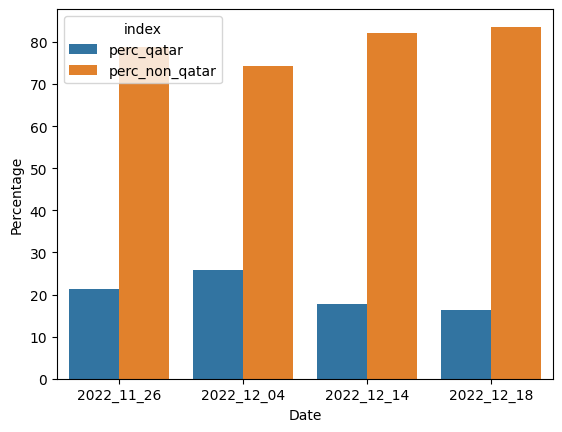

In [14]:
ax = sns.barplot(data=tweet_counts_df.loc[tweet_counts_df['index'].isin(['perc_qatar', 'perc_non_qatar'])], x='variable', y='value', hue='index')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage')

Interesting. 
- we can see that there isn't *that* much variability when it comes to the proportion of tweets in our samples which mention `qatar`, but we can observe a minimal downward trend towards the final stages of the tournament - at least in the data we've collected.
- this may indicate that people tweeting about the tournament focused more on the football rather than its surroundings, but this is merely conjecture. 

#### Preparing data for sentiment analysis

Having identified our pertinent tweets, let's now focus on extracting and cleaning the text from them.  

We will perform some pre-processing on tweet text: We want to remove stopwords (e.g. `I, you, an, and, with`), as well as other, twitter-specific redundant text, such as `RT` or handles (`@bob`) as these do not add to the analysis. We may consider performing lemmatization, although this appears already to be included in the `Vader` library we will be utilising for sentiment analysis.

In [15]:
to_remove = [
    'RT @[\w]*:', # RTs
    '@[\w]*', # mentions
    'https?://[A-Za-z0-9./]*' # URLs
]

In [ ]:
sentiment_df = pd.DataFrame()

for date in qatar_tweets:
    sentiment_df = pd.concat([sentiment_df, pd.DataFrame(qatar_tweets[date])[['id', 'created_at', 'text']]])

In [ ]:
sentiment_df = sentiment_df.reset_index(drop=True)

Let's now perform the cleaning

In [ ]:
sentiment_df['text'] = clean_tweets(sentiment_df['text'])

Let's go ahead and run our vader-based sentiment analysis, and attach it to this data frame

In [ ]:
scores = []

for idx, row in sentiment_df.iterrows():
    tmp = sentiment_analyser.polarity_scores(row['text'])
    scores.append(tmp)

In [ ]:
sentiment_df = pd.concat([sentiment_df, pd.DataFrame(scores)], axis=1)

Let's detect what language we think we're dealing with here, and then include that in our analysis.

In [ ]:
langs = []

for idx, row in sentiment_df.iterrows():
    try:
        tmp = detect(row['text'])
        langs.append(tmp)
    except LangDetectException:
        tmp = None
        langs.append(tmp)

In [ ]:
sentiment_df['predicted_language'] = langs

In [242]:
#sentiment_df.to_csv(EXPORT_PATH+'qatar_tmp_scores_languages.csv', index=False)
#sentiment_df = pd.read_csv(EXPORT_PATH+'qatar_tmp_scores_languages.csv')

Amazing, we were able to add predicted languages to our sentiment df; even though it took something like 69 minutes.  
Let's have a look at the distribution of languages in our tweets.

In [21]:
language_counts_df = sentiment_df.groupby('predicted_language').count().reset_index()[['predicted_language', 'id']]
language_counts_df = language_counts_df.loc[language_counts_df['id']>1000]

Dropping languages which appear less than 1000 times.

Text(0, 0.5, 'Count')

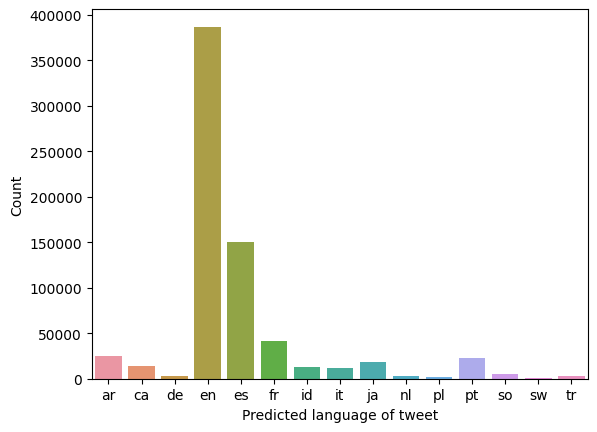

In [22]:
ax = sns.barplot(language_counts_df, x='predicted_language', y='id')
ax.set_xlabel('Predicted language of tweet')
ax.set_ylabel('Count')

Interesting - so we can see that there are a number of languages besides english here. Spanish is very comon, while French, Portuguese, Arabic and Japanese are also quite common. 

However -- our sentiment algorithm will only have classified sentiment for **ENGLISH** tweets. Really, this is also all we can feasibly make sense of. For this purpose, we'll discard tweets (for now) from the analysis. 

In [34]:
english_qatar_tweets_df = sentiment_df.loc[sentiment_df['predicted_language']=='en'].reset_index(drop=True)
english_qatar_tweets_df['pos'] = english_qatar_tweets_df['pos'].astype(float)

This still leaves us with `386607` tweets. 

#### Visualising and analysing the sentiment of our 4 chunks of qatar-mentioning, english-language tweets.

Now, let's dig a little deeper into our sentiment-annotated tweets. We are using the `Vader` sentiment algorithm. *'VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media'* [see here: https://github.com/cjhutto/vaderSentiment]. The classification works by matching the text encountered in a given text unit (here - tweets) to lexicons with which contained reference terms (and combinations of terms, e.g. phrases). These are then combined to produce scores. The algorithm also considers punctuation, capitalisation, and multiple words in conjunction to estimate sentiment polarity.  

Using this algorithm, we have created `4 scores` which represent `negative`, `neutral`, `positive` and `compound` sentiment for each of our tweets. These range from `0-1` for the non-compound scores; and from `-1 to +1` for the compound score. See the slice of our sample of english tweets below for an example of what this looks like in our dataset: 

In [35]:
english_qatar_tweets_df.head()

,id,created_at,text,neg,neu,pos,compound,predicted_language
0,1596349275914788864,2022-11-26T03:45:00.000Z,Qatar is just the second host nation to ever g...,0.000,1.000,0.000,0.0000,en
1,1596349282210418688,2022-11-26T03:45:02.000Z,A serbian fan raised Palestine flag during Br...,0.000,0.859,0.141,0.3182,en
2,1596349282915069952,2022-11-26T03:45:02.000Z,#QatarAWorldCup2022 #FIFAWorldCup \n#FIFAWorld...,0.000,1.000,0.000,0.0000,en
3,1596349294982094849,2022-11-26T03:45:05.000Z,meme token supporting the WorldCup vibes wit...,0.096,0.740,0.164,0.2732,en
4,1596349302825447424,2022-11-26T03:45:07.000Z,Qatar becomes the first country eliminated at...,0.000,1.000,0.000,0.0000,en


To begin, let's have a look at some core summary statistics for the assigned sentiment scores. 

In [36]:
print(f'Mean, `neg` score: {np.mean(english_qatar_tweets_df["neg"])}')
print(f'Median, `neg` score: {np.median(english_qatar_tweets_df["neg"])}')

print(f'Mean, `neu` score: {np.mean(english_qatar_tweets_df["neu"])}')
print(f'Median, `neu` score: {np.median(english_qatar_tweets_df["neu"])}')

print(f'Mean, `pos` score: {np.mean(english_qatar_tweets_df["pos"])}')
print(f'Median, `pos` score: {np.median(english_qatar_tweets_df["pos"])}')

print(f'Mean, `compound` score: {np.mean(english_qatar_tweets_df["compound"])}')
print(f'Median, `compound` score: {np.median(english_qatar_tweets_df["compound"])}')

Mean, `neg` score: 0.040685117070697656
Median, `neg` score: 0.0
Mean, `neu` score: 0.8359120676454459
Median, `neu` score: 0.853
Mean, `pos` score: 0.12340533465768588
Median, `pos` score: 0.08
Mean, `compound` score: 0.22226100868071716
Median, `compound` score: 0.0


OK, so this is indicating the following: `Neutral` sentiment appears to be dominating. This is likely affecting the `compound` value more than pos or neg. But - there doesn't appear to be that much in the `neg` department; especially when we compare medians between the different groups.

Let us now have a look at the **`distribution`** of sentiment across our different scores.  
We will do this by producing kernel density plots. These are essentially the same histograms, with the different that they contain a smoothed line rather than a finite number of bins, which is more suitable to a very continuous score (and not a count), as we have it here.

<AxesSubplot: ylabel='Density'>

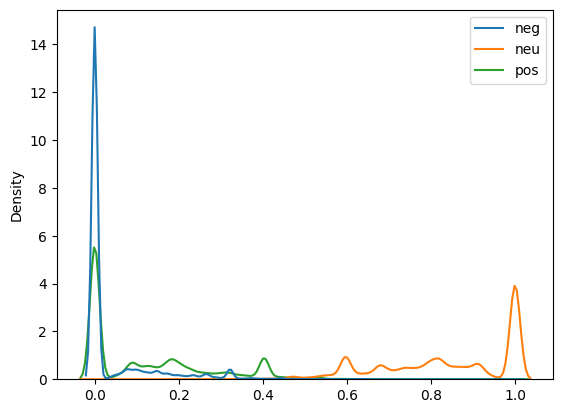

In [37]:
sns.kdeplot(data=english_qatar_tweets_df[['neg', 'neu', 'pos']])

This graph isn't super easy to interpret -- but what we are seeing here is the following (which confirms suspicions from looking at means/medians):
- the vast majority of `neg` values are zero, meaning that the algorithm didn't detect any negative language in the thusly labelled tweets
- there's also a good chunk of tweets with zero `pos` -- meaning the inverse
- and, our third peak is at 1.0 for `neu`, meaning that for that proportion, we find a high proportion of tweets where the algorithm detected complete neutrality - which may, or may not simply indicate that the algorithm encountered its limits.  

Let's now look at the same for the `compound` score; which we are most interested in.

<AxesSubplot: xlabel='compound', ylabel='Density'>

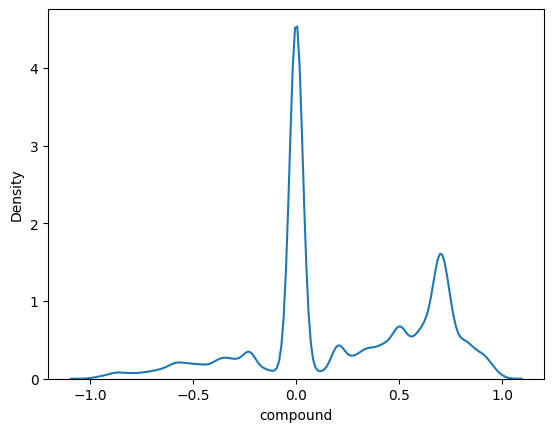

In [29]:
sns.kdeplot(data=english_qatar_tweets_df, x='compound')

Interesting. This is reproducing what we have seen previously:
- a lot of neutrality (or, an indication of not particularly well-working machine)
- definitely more positively than negatively classified tweets.

#### Plotting sentiment over time

Now, for the most interesting thing -- plotting sentiment over time.  
We are faced with a number of difficulties here: 
- we don't have a continuous stream of data for the entire timeframe. 
- for the data we have, we can't trust that it is 100% of the timeframe that it purports to represent. Both twitter's streaming and search capabilities are entirely black boxes; meaning we have to take what we have and make assumptions (or somehow quantify our assumptions). 

This results in a bunch of caveats:
- we can't really draw a straight line from left to right charting the evolution of sentiment from time `t0` to `t1`. 
- we shouldn't even (really) smooth out our individual data points and connect them; as there may be ones in between (which we are essentially interpolating based on the preceding and following data points). 

BUT, we will do this anyway, in the knowledge that we have to work with what we have. 
- We will try to make the distinction between the 4 different time periods / data collection periods clear
- we do this by making 4 distinct time plots
- If we are missing data for a period of time; ~~we will not interpolate it but leave a hole~~, we will interpolate it, as it just doesn't really make sense otherwise; and allows us a little more interpretability

In [38]:
# start by converting string to timestamp
english_qatar_tweets_df['created_at'] = pd.to_datetime(english_qatar_tweets_df['created_at'])

In [ ]:
#english_qatar_tweets_df.to_csv(EXPORT_PATH+'english_qatar_tweets.csv', index=False)

In [52]:
grouped_timestamps_df = english_qatar_tweets_df.groupby(pd.Grouper(key='created_at', freq='10Min')).mean().reset_index()

/tmp/ipykernel_7847/97932774.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



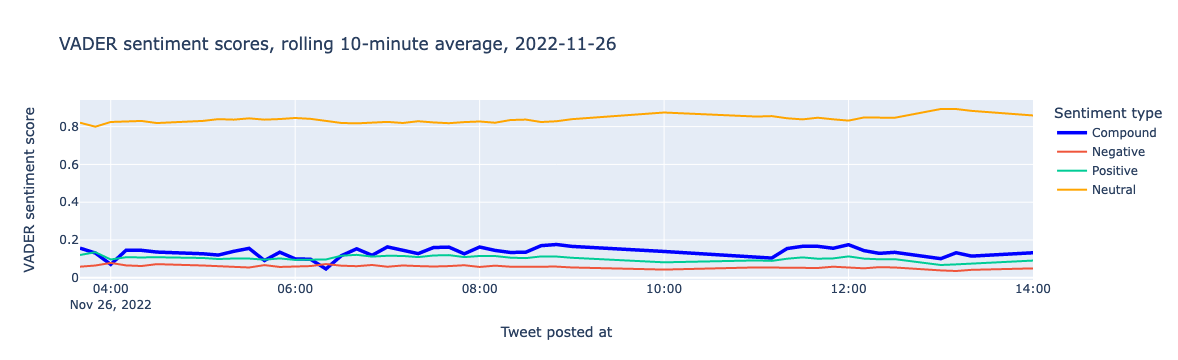

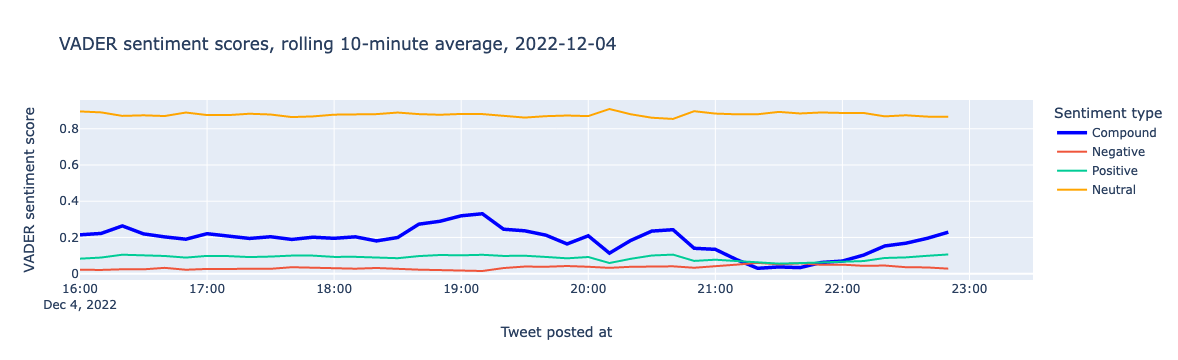

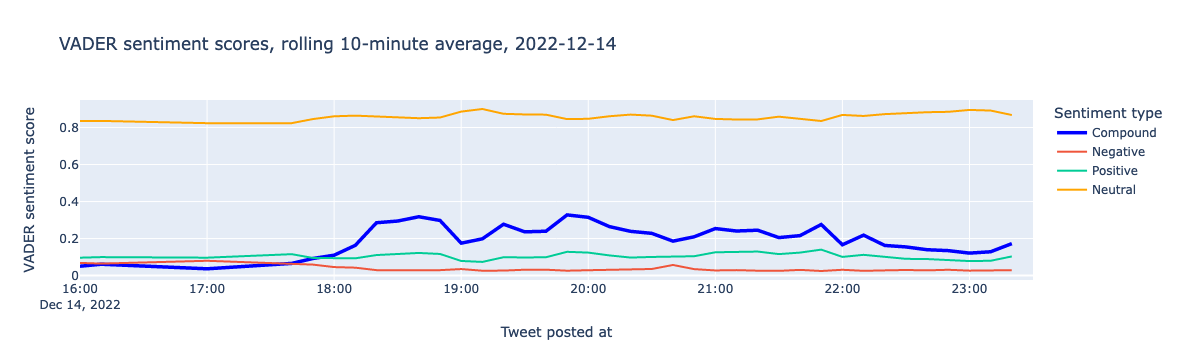

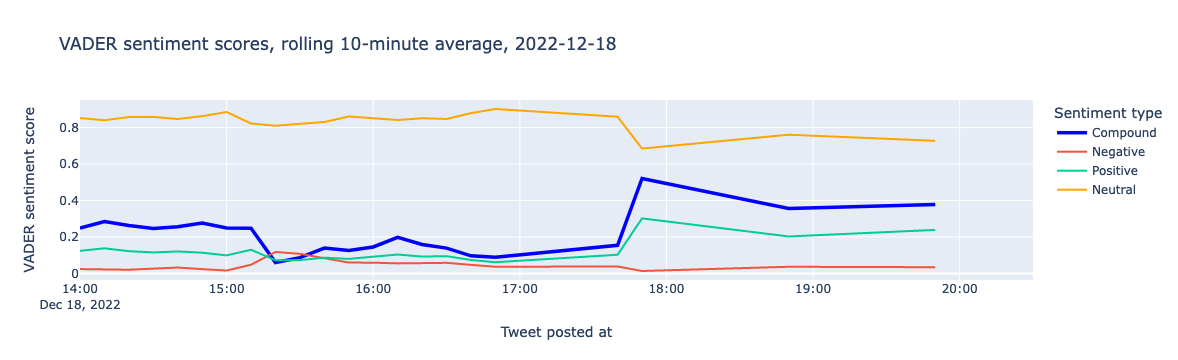

In [89]:
dates = ['2022-11-26', '2022-12-04', '2022-12-14', '2022-12-18']

date_ranges = [
    ['2022-11-26 03:00', '2022-11-26 14:00'],
    ['2022-12-04 16:00', '2022-12-04 23:30'],
    ['2022-12-14 16:00', '2022-12-14 23:30'],
    ['2022-12-18 14:00', '2022-12-18 20:30']
]

for i, range in enumerate(date_ranges):
    subset_df = grouped_timestamps_df.query(f'created_at.between("{range[0]}", "{range[1]}")')

    fig = go.Figure()
    fig.add_scatter(name='Compound', x=subset_df['created_at'], y=subset_df['compound'], line=dict(color="blue", width=3.5) )

    fig.add_scatter(name='Negative', x=subset_df['created_at'], y=subset_df['neg'], fillcolor='red')
    fig.add_scatter(name='Positive', x=subset_df['created_at'], y=subset_df['pos'], fillcolor='green')
    fig.add_scatter(name='Neutral', x=subset_df['created_at'], y=subset_df['neu'], line=dict(color="orange"))
    fig.update_traces(connectgaps=True)
    fig.update_layout(
        title=f'VADER sentiment scores, rolling 10-minute average, {dates[i]}',
        xaxis_title='Tweet posted at',
        yaxis_title='VADER sentiment score',
        legend_title='Sentiment type'
    )
    fig.show()

Some further caveats re these graphs:
- We are looking at 10-minute averages here. If we'd gone with *all* our data points, we're essentially left with big rectangles which look precisely the same for everything - as, at the individual tweet-level, there is indeed quite a bit of variation in classified sentiment. 
- Further, we are interpolating gaps. This should be kept in mind, especially for everything post 6 PM on 2022-12-18 (where we hardly have any data; as we ran out of our quota more or less around 5 PM on final day)
- There may also be further gaps caused by the fact that we're excluding non-english tweets. Again, we can't trust that we're getting **everything** from Twitter, so if at times Spanish-language tweets were the majority, this doesn't mean that there *weren't* any English tweets -- it means that the volume of English & Spanish tweets at that given moment in time exceeded 1% of all tweets, and thus our free access didn't permit us to collect it.

**Now, some interpretations of these graphs**:
- A non-detailed glance at these graphs seems to indicate that the overall sentiment of tweets mentioning `qatar` has gone up over time. (BUT -- can we compare the middle of the night tweets on the 26th to the during the game tweets later on? Not so sure...)
- Overall, the positivity of classified sentiment is higher than perhaps expected. 
- Throughout our data collection period however, there appear to be, on the whole, stronger `positive` signals captured by VADER than `negative` ones in our tweets. 
- `Neutral` is huge: whether this is the algorithm or it's actually the case (probably a bit of both)

**Let us now have a quick look, just as a bit of a sanity check, how the average sentiment looks when we average it per hour, and per sample as a whole.**

In [91]:
ten_minute_sentiment_df = grouped_timestamps_df 

In [ ]:
hourly_sentiment_df = english_qatar_tweets_df.groupby(pd.Grouper(key='created_at', freq='60Min')).mean().dropna().reset_index()
chunk_sentiment_df = english_qatar_tweets_df.groupby(pd.Grouper(key='created_at', freq='24h')).mean().dropna().reset_index()

**HOURLY**

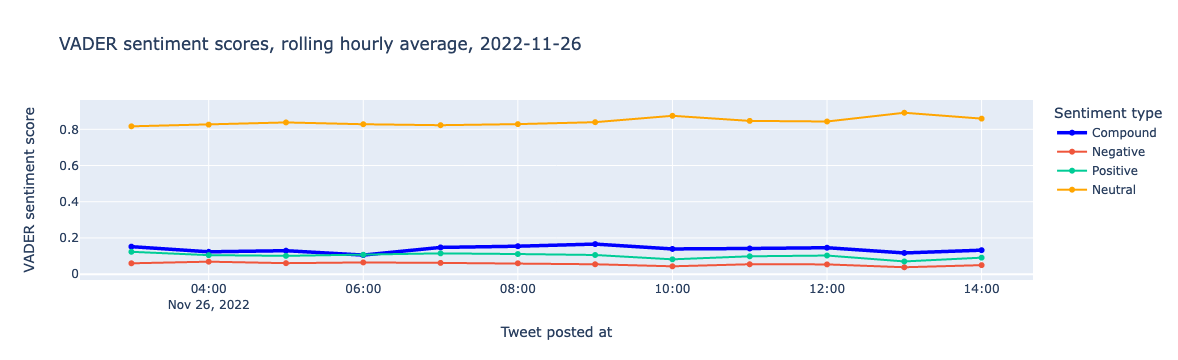

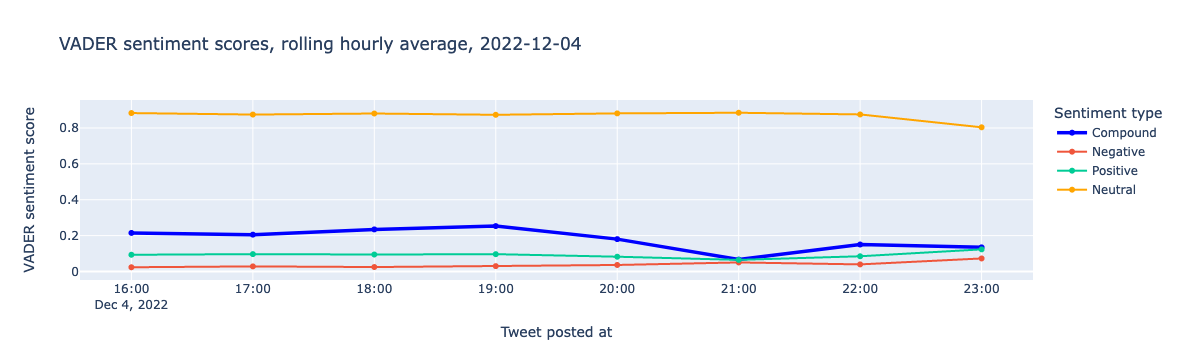

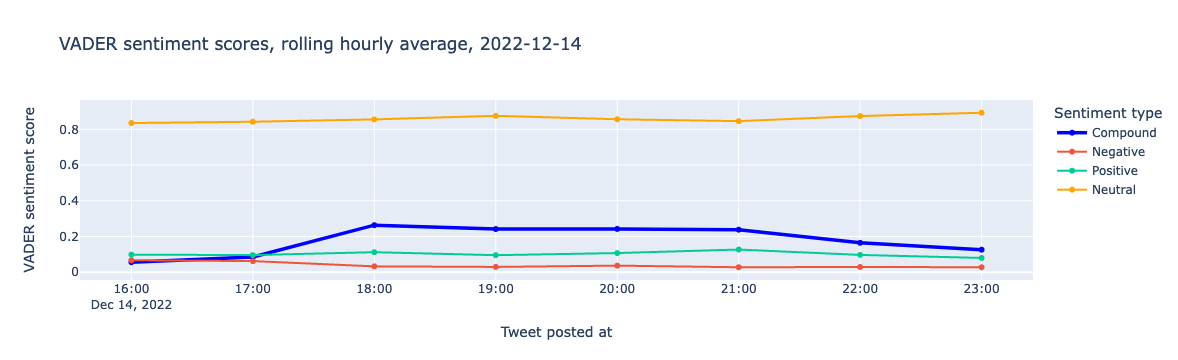

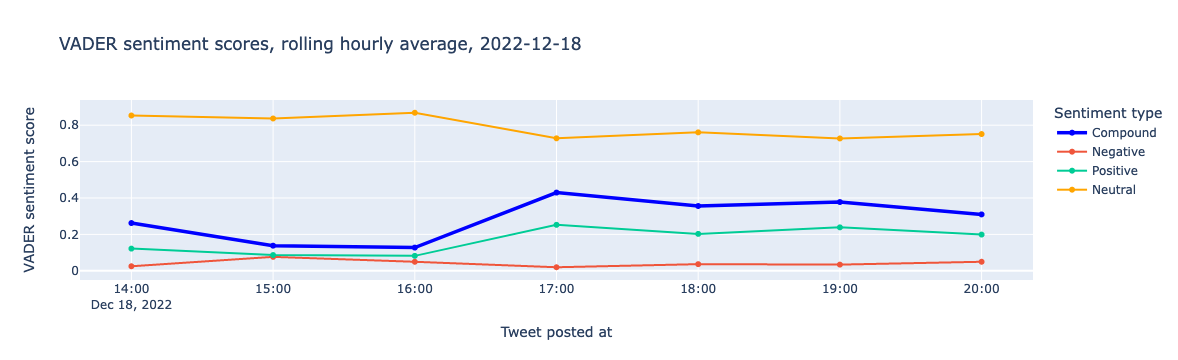

In [102]:
dates = ['2022-11-26', '2022-12-04', '2022-12-14', '2022-12-18']

date_ranges = [
    ['2022-11-26 03:00', '2022-11-26 14:00'],
    ['2022-12-04 16:00', '2022-12-04 23:30'],
    ['2022-12-14 16:00', '2022-12-14 23:30'],
    ['2022-12-18 14:00', '2022-12-18 20:30']
]

for i, range in enumerate(date_ranges):
    subset_df = hourly_sentiment_df.query(f'created_at.between("{range[0]}", "{range[1]}")')

    fig = go.Figure()
    fig.add_scatter(name='Compound', x=subset_df['created_at'], y=subset_df['compound'], line=dict(color="blue", width=3.5) )

    fig.add_scatter(name='Negative', x=subset_df['created_at'], y=subset_df['neg'], fillcolor='red')
    fig.add_scatter(name='Positive', x=subset_df['created_at'], y=subset_df['pos'], fillcolor='green')
    fig.add_scatter(name='Neutral', x=subset_df['created_at'], y=subset_df['neu'], line=dict(color="orange"))
    fig.update_traces(connectgaps=True)
    fig.update_layout(
        title=f'VADER sentiment scores, rolling hourly average, {dates[i]}',
        xaxis_title='Tweet posted at',
        yaxis_title='VADER sentiment score',
        legend_title='Sentiment type'
    )
    fig.show()

This clearly emphasises the effect that we've already seen. 

In which case, this is perhaps the more useful and easily interpretable graph. 

**DAILY**

In [115]:
tmp_df = pd.melt(chunk_sentiment_df, id_vars=['created_at'], ignore_index=False).reset_index()

Text(0.5, 1.0, 'CHECK LEGEND - CONFUSING COLOURS')

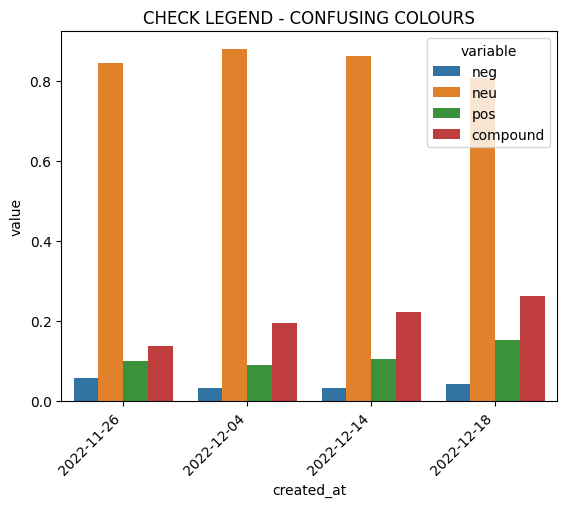

In [122]:
ax = sns.barplot(tmp_df, x='created_at', y='value', hue='variable')
ax.set_xticklabels(dates, rotation=45, horizontalalignment='right')
ax.set_title('CHECK LEGEND - CONFUSING COLOURS')

#### Summary
So, we've had a look at the VADER sentiment for english-language tweets mentioning `qatar` (which, on the whole, were less than 25% of all our tweets). We found a bunch of things:
- While the VADER algorithm may be the best off-the-shelf tool that doesn't require hand-labelling of tweets, it has left an awfully high amount of tweets labelled as 'neutral', regardless of which sample they were from. We are skeptical as to whether this is down to the true, unobserved sentiment of the corpora, or perhaps more an artifact of a lexicon underlying the analysis which may not contain context-specific terms which would actually contribute to positive or negative sentiment. 
- However, the algorithm's ability to segment into different categories of sentiment polarity gives us some more wiggle room. 
- We find that aggregated measures of compound and positive sentiment appear to have increased in later samples; while aggregated measures of negative sentiment have decreased or stayed constant when comparing the different samples/corpora. 

#### Bonus: Extracting key terms associated with very positive and very negative tweets.

We might be interested in the commonalities of those tweets which VADER considers highly positive or negative.  

In order to investigate this, we do the following:
- set cutoff points (this is arbitrary, but we will go with **`>.5`** for the `pos` and `neg` scores.)
- extract tweet text of tweets where this is the case
- build frequency tables of these words and visualise them. 

Note: We will only be dealing with uni-grams, not n-grams (n words which co-occur)

In [159]:
def convert_to_float(val):
    try:
        val = float(val)
    except ValueError:
        val = 0.0

    return val

convert_vectorized = np.vectorize(convert_to_float)

In [160]:
sentiment_df['pos'] = convert_vectorized(sentiment_df['pos'])

In [161]:
sentiment_df['pos'] = sentiment_df['pos'].astype(float)

In [183]:
v_pos_df = sentiment_df.loc[sentiment_df['pos']>0.5].reset_index(drop=True)

In [184]:
v_neg_df = sentiment_df.loc[sentiment_df['neg']>0.5].reset_index(drop=True)

Total n tweets:

In [185]:
print(f'N v pos tweets: {len(v_pos_df)}')
print(f'N v neg tweets: {len(v_neg_df)}')

N v pos tweets: 6136
N v neg tweets: 1756


Stemming and lemmatizing our tweets

In [191]:
pos_words = []

for row, idx in v_pos_df.iterrows():
    tmp = re.sub(r'[^\w\s]', '', v_pos_df['text'][row])
    pos_words += tmp.split()

In [199]:
pos_words = remove_stopwords(pos_words)
pos_words = word_lemmatizer(pos_words)

In [203]:
pos_words = [x.lower() for x in pos_words]

In [204]:
neg_words = []

for row, idx in v_neg_df.iterrows():
    tmp = re.sub(r'[^\w\s]', '', v_neg_df['text'][row])
    neg_words += tmp.split()

In [205]:
neg_words = remove_stopwords(neg_words)
neg_words = word_lemmatizer(neg_words)
neg_words = [x.lower() for x in neg_words]

In [211]:
pos_words_counts = dict(zip(Counter(pos_words).keys(), Counter(pos_words).values()))
pos_words_counts = dict(sorted(pos_words_counts.items(), key=lambda x:x[1], reverse=True))

In [214]:
neg_words_counts = dict(zip(Counter(neg_words).keys(), Counter(neg_words).values()))
neg_words_counts = dict(sorted(neg_words_counts.items(), key=lambda x:x[1], reverse=True))

Now to produce a wordcloud for the top positive and negative words

In [218]:
wordcloud = WordCloud().generate(' '.join(pos_words))

Positive

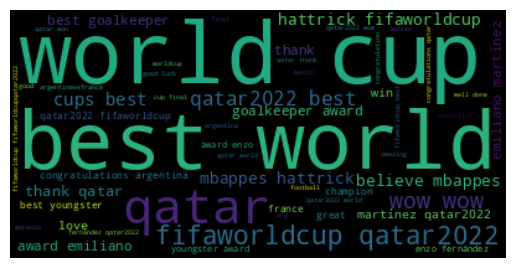

In [221]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Negative

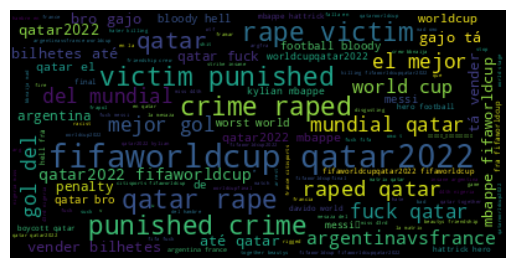

In [222]:
wordcloud = WordCloud().generate(' '.join(neg_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

And, finally, the top 50 terms and frequencies for both of these... 

In [238]:
pos_words_df = pd.DataFrame.from_dict(pos_words_counts.items()).reset_index(drop=True)[:100]
pos_words_df = pos_words_df.rename(columns={0 : 'word', 1 : 'freq'})

In [239]:
pos_words_df

,word,freq
0,best,3296
1,world,3236
2,cup,2935
3,ever,2744
4,qatar,1646
...,...,...
95,its,38
96,wish,37
97,all,37
98,hope,36


In [240]:
neg_words_df = pd.DataFrame.from_dict(neg_words_counts.items()).reset_index(drop=True)[:100]
neg_words_df = neg_words_df.rename(columns={0 : 'word', 1 : 'freq'})

In [241]:
neg_words_df

,word,freq
0,qatar,921
1,fifaworldcup,517
2,qatar2022,510
3,fuck,194
4,crime,187
...,...,...
95,goal,11
96,today,11
97,frapol,11
98,43rd,11


I'll leave the interpretation or usefulness of this stuff to the reader. 

#### Final: Exporting data

Now to export all the key datasets we've produced here so they can be used in other contexts.

In [243]:
QATAR_EXPORT_PATH = EXPORT_PATH+'qatar_tweets/'

In [244]:
language_counts_df.to_csv(QATAR_EXPORT_PATH+'language_counts.csv', index=False)
sentiment_df.to_csv(QATAR_EXPORT_PATH+'sentiment.csv', index=False)
english_qatar_tweets_df.to_csv(QATAR_EXPORT_PATH+'english_qatar_tweets.csv', index=False)
ten_minute_sentiment_df.to_csv(QATAR_EXPORT_PATH+'ten_minute_sentiment.csv', index=False)
hourly_sentiment_df.to_csv(QATAR_EXPORT_PATH+'hourly_sentiment.csv', index=False)
chunk_sentiment_df.to_csv(QATAR_EXPORT_PATH+'chunk_sentiment.csv', index=False)
v_pos_df.to_csv(QATAR_EXPORT_PATH+'v_pos_tweets.csv', index=False)
v_neg_df.to_csv(QATAR_EXPORT_PATH+'v_neg_tweets.csv', index=False)
pos_words_df.to_csv(QATAR_EXPORT_PATH+'v_pos_word_frequencies.csv', index=False)
neg_words_df.to_csv(QATAR_EXPORT_PATH+'v_neg_word_frequencies.csv', index=False)